# 采用Fashion-MNIST 数据集

In [30]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import time

## 下载数据集

In [9]:
# 通过ToTensor实例将图像数据从PIL类型转换为32位浮点数格式
# 并除以255进行归一化
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data/", 
                                                train=True,
                                               transform=trans,
                                               download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data/",
                                              train=False,
                                              transform=trans,
                                              download=True)

In [10]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [14]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

## 可视化数据集

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002093E87BAC8>,
      dtype=object)

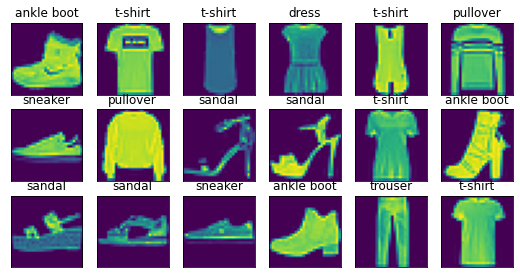

In [23]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18,28,28),3,6,titles=get_fashion_mnist_labels(y))

In [34]:
batch_size = 64
def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())
start = time.time()
for X, y in train_iter:
    continue

f'{time.time()-start:2f}sec'

'3.075983sec'